# 0. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle

import warnings
warnings.filterwarnings("ignore")

## 0.0 Functions

In [3]:
def cross_val_smote(X_train, y_train, modelo, metrica):
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2)

    for train_idx, val_idx in kfold.split( X_train, y_train):
        Xtrain_fold = X_train.iloc[train_idx].values
        ytrain_fold = y_train.iloc[train_idx].values.reshape(-1, 1)

        Xval_fold = X_train.iloc[val_idx].values
        yval_fold = y_train.iloc[val_idx].values.reshape(-1, 1)

        sm = SVMSMOTE(random_state = 11, k_neighbors = 3)

        Xtrain_fold_res, ytrain_fold_res = sm.fit_resample(Xtrain_fold, ytrain_fold)

        modelo.fit(Xtrain_fold_res, ytrain_fold_res)

        pred = modelo.predict(Xval_fold)

        lista_metrica = []

        lista_metrica.append(metrica(y_true = yval_fold, y_pred = pred))

    return np.mean(lista_metrica)

In [4]:
def bayes_search(X, y, param_grid, model, score, n_folds = 5):
    
    folds = StratifiedKFold(n_splits = n_folds, shuffle = True)
    opt = BayesSearchCV(estimator = model, search_spaces = param_grid, scoring = score, cv = folds)
    opt.fit(X, y)

    print("Melhores parâmetros:", opt.best_params_)
    print()
    print("Melhor score:", opt.best_score_)

In [5]:
def model_evaluation(X_train, y_train, model, nome_modelo, folds = 5):

    ac_treino = np.round(balanced_accuracy_score(y_true = y_train, y_pred = model.predict(X_train)), 2)
    ac_cv = np.round(np.mean(cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "balanced_accuracy", cv = folds)), 2)
    
    f1_treino = np.round(f1_score(y_true = y_train, y_pred = model.predict(X_train)), 2)
    f1_cv = np.round(np.mean(cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "f1", cv = folds)), 2)

    row_evaluation = {"Modelo": nome_modelo, "BalancedAc(treino)": ac_treino, "BalancedAc(Cross Val.)": ac_cv, "f1(treino)": f1_treino, "f1(Cross Val.)": f1_cv}

    return row_evaluation

In [6]:
def model_evaluation2(X_train, y_train, model, nome_modelo):

    ac_treino = np.round(balanced_accuracy_score(y_true = y_train, y_pred = model.predict(X_train)), 3)
    ac_cv = np.round(cross_val_smote(modelo = model, X_train = X_train, y_train = y_train, metrica = balanced_accuracy_score), 3)
    
    f1_treino = np.round(f1_score(y_true = y_train, y_pred = model.predict(X_train)), 3)
    f1_cv = np.round(cross_val_smote(modelo = model, X_train = X_train, y_train = y_train, metrica = f1_score), 3)

    row_evaluation = {"Modelo": nome_modelo, "BalancedAc(treino)": ac_treino, "BalancedAc(Cross Val.)": ac_cv, "f1(treino)": f1_treino, "f1(Cross Val.)": f1_cv}

    return row_evaluation

## 0.1 Load data

In [7]:
df = pd.read_csv("Employee.csv")
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


**Columns Description**

- Education -> EDUCATION LEVEL
- JoiningYear -> YEAR OF JOINING COMPANY
- City -> CITY OFFICE WHERE POSTED
- PaymentTier -> PAYMENT TIER: 1: HIGHEST 2: MID LEVEL 3:LOWEST
- Age -> CURRENT AGE
- Gender -> GENDER OF EMPLOYEE
- EverBenched -> EVER KEPT OUT OF PROJECTS FOR 1 MONTH OR MORE
- ExperienceInCurrentDomain -> EXPERIENCE IN CURRENT FIELD
- LeaveOrNot -> WHETHER EMPLOYEE LEAVES THE COMPANY IN NEXT 2 YEARS

# 1. Data Description

The description of the data will be carried out and also the Descriptive Statistics to describe the data.

## 1.1 Data Size

In [8]:
print("N° linhas:", df.shape[0])
print("N° colunas:", df.shape[1])

N° linhas: 4653
N° colunas: 9


## 1.2 Data Types

In [9]:
df.dtypes

Education                    object
JoiningYear                   int64
City                         object
PaymentTier                   int64
Age                           int64
Gender                       object
EverBenched                  object
ExperienceInCurrentDomain     int64
LeaveOrNot                    int64
dtype: object

## 1.3 Check NaN

In [10]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## 1.4 Descriptive Statistical

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
JoiningYear,4653.0,2015.062970,1.863377,2012.0,2013.0,2015.0,2017.0,2018.0
PaymentTier,4653.0,2.698259,0.561435,1.0,3.0,3.0,3.0,3.0
Age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
ExperienceInCurrentDomain,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
LeaveOrNot,4653.0,0.343864,0.475047,0.0,0.0,0.0,1.0,1.0


## 1.5 Lower Case Columns

To be easiest to manipulate, i will turn all columns names in lowercase.

In [12]:
df.columns = df.columns.str.lower()

In [13]:
df.columns

Index(['education', 'joiningyear', 'city', 'paymenttier', 'age', 'gender',
       'everbenched', 'experienceincurrentdomain', 'leaveornot'],
      dtype='object')

In [14]:
df.columns = ['education', 'joining_year', 'city', 'payment_tier', 'age', 'gender',
       'ever_benched', 'experience_current_domain', 'leave']

# 2. Feature Engineering

## 2.1  Feature Engineering

In [15]:
df["time_employed"] = 2018 - df.joining_year

# 3. Exploratory Data Analysis

In the Exploratory Data Analysis the data will be better analized and hypotheses will be raised in order to generate insights for the human resources team and also identify the correlation between variables and 'LeaveOrNot'.


## 3.1 Univariate Analysis

In [16]:
num_col = ["age", "experience_current_domain", "time_employed"]
cat_col = ["education", "city", "payment_tier", "gender", "ever_benched"]
target_col = "leave"

### 3.1.1 Response Variable

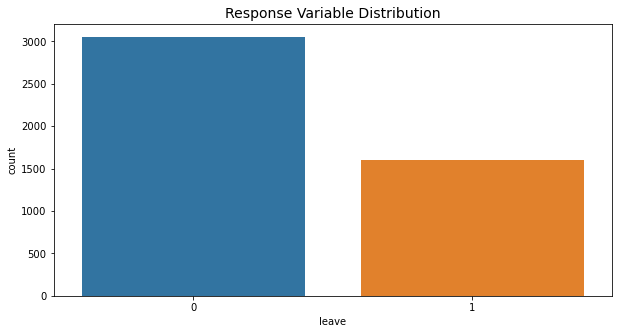

In [17]:
plt.figure(figsize = [10,5])
sns.countplot(df["leave"])
plt.title("Response Variable Distribution", fontsize = 14)
plt.show()

In [18]:
(df.leave.value_counts() / df.shape[0]) * 100

0    65.613583
1    34.386417
Name: leave, dtype: float64

Our dataset is a little bit inmbalanced, we will deal with this later in the notebook.

### 3.1.2 Numerical Variables

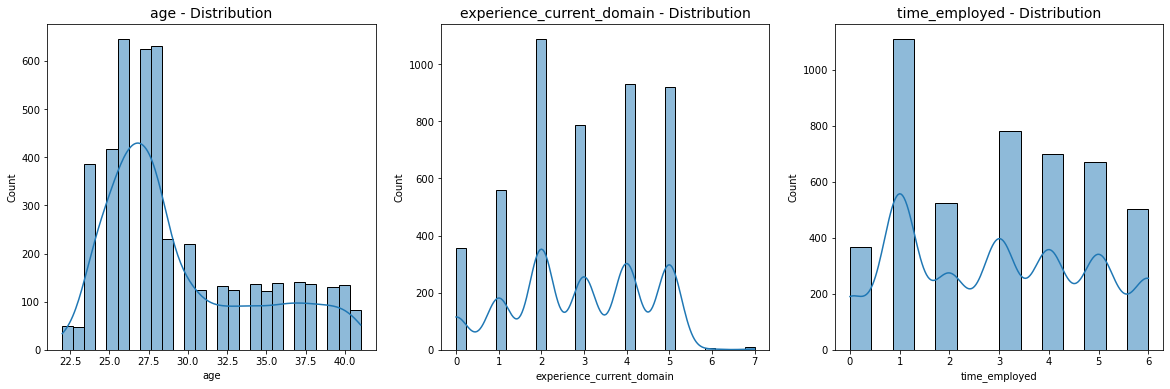

In [19]:
plt.figure(figsize = [20, 6])

for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    sns.histplot(df[i], kde = True)
    plt.title(i + " - Distribution", fontsize = 14)
plt.show()

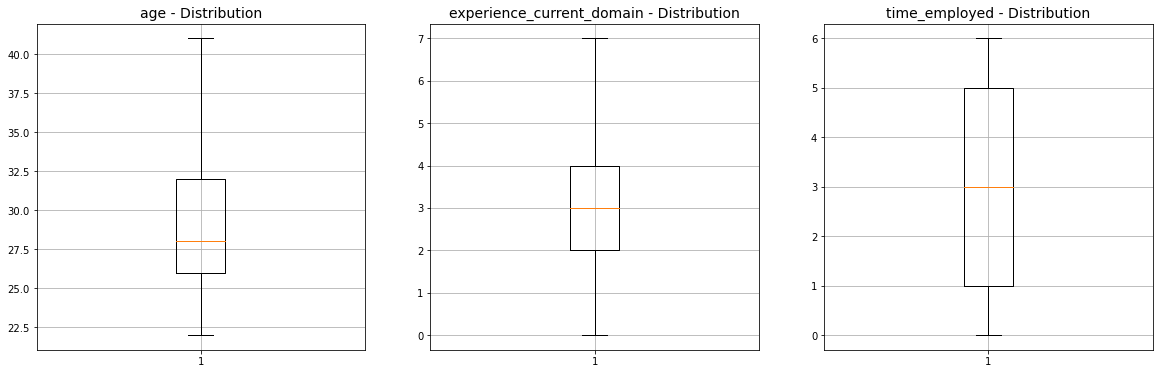

In [20]:
plt.figure(figsize = [20, 6])

for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    plt.boxplot(df[i])
    plt.title(i + " - Distribution", fontsize = 14)
    plt.grid()
plt.show()

### 3.1.3 Categorical Variables

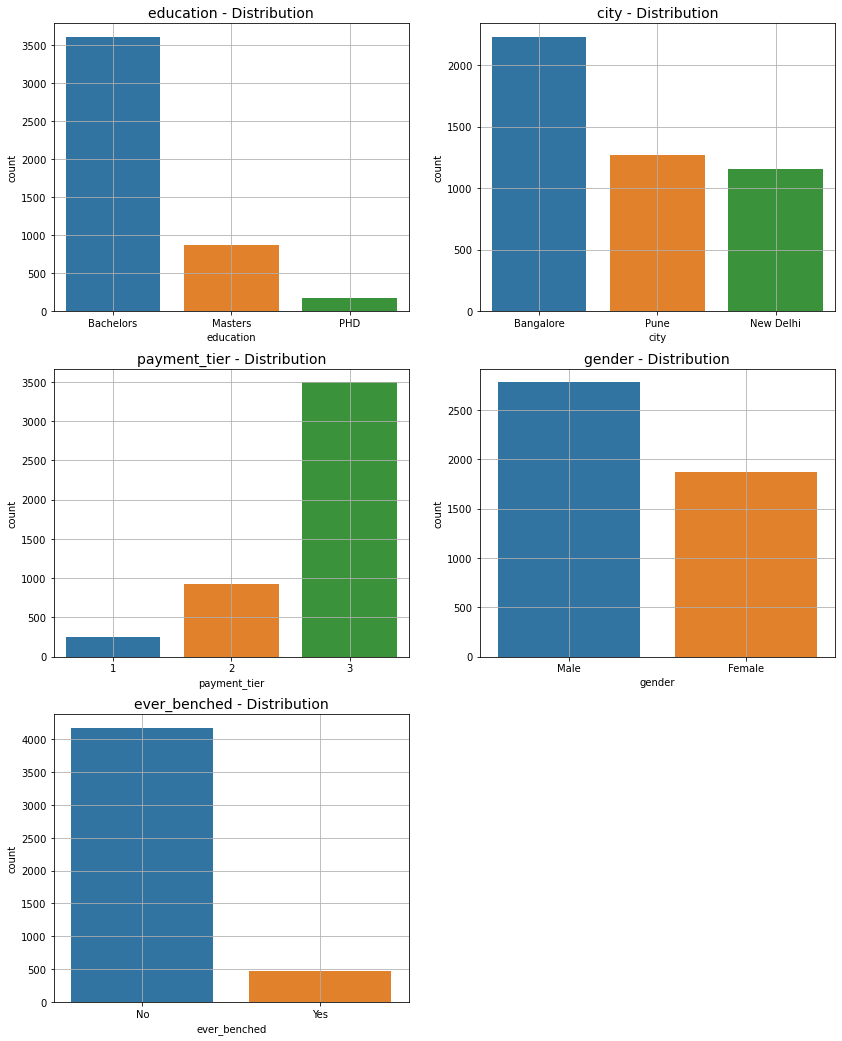

In [21]:
plt.figure(figsize = [14, 18])

for i in cat_col:
    plt.subplot(3, 2, cat_col.index(i) + 1)
    sns.countplot(df[i])
    plt.title(i + " - Distribution", fontsize = 14)
    plt.grid()
plt.show()

## 3.2 Bivariate Analysis

Here we will analyze the relationship between the attributes and the target variable, in order to discover the characteristics of an employee who leaves the company.

### 3.2.1 Numerical Variables

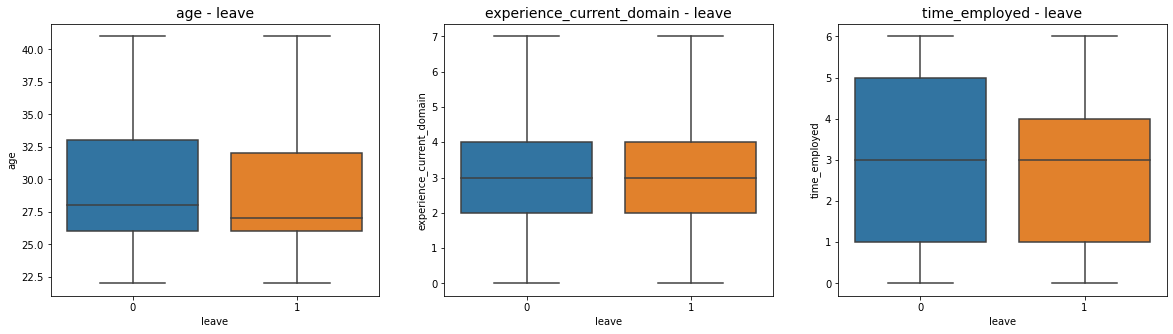

In [22]:
plt.figure(figsize = [20, 5])
for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    sns.boxplot(df["leave"], df[i])
    plt.title(i + " - leave", fontsize = 14)    
plt.show()

### 3.2.2 Categorical Variables

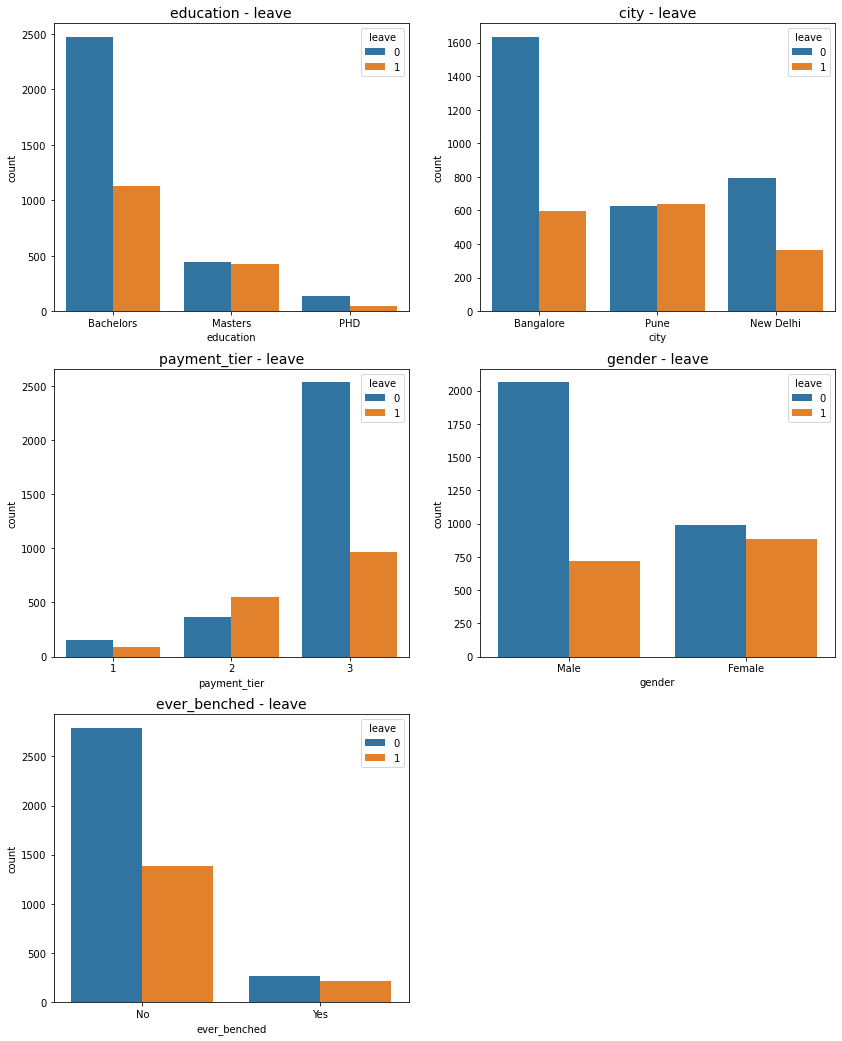

In [23]:
plt.figure(figsize = [14, 18])
for i in cat_col:
    plt.subplot(3, 2, cat_col.index(i) + 1)
    sns.countplot(df[i], hue = df["leave"])
    plt.title(i + " - leave", fontsize = 14)    
plt.show()

## 3.3 Particulars of a employee who leave the company

### P1: Employees with less time into the company

Employees who left the company have an average of years in the company of 2.46 years while who doesn't left have an average of years of 3.18.

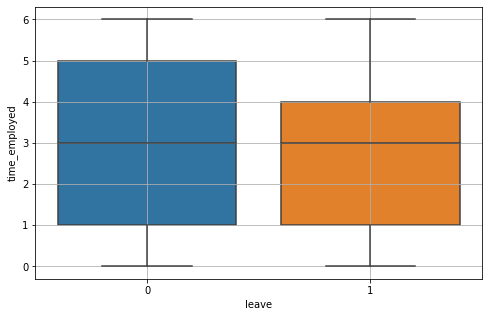

Mean - years employed - Left: 2.469375

Mean - years employed - Not Left: 3.182115951523092


In [24]:
plt.figure(figsize = [8, 5])
sns.boxplot(df["leave"], df["time_employed"])
plt.grid()
plt.show()

print("Mean - years employed - Left:",np.mean(df[df["leave"] == 1]["time_employed"]))
print()
print("Mean - years employed - Not Left:",np.mean(df[df["leave"] == 0]["time_employed"]))

### P2: Employees with Master degree

48,8% of the employees with Master Degree left the company.

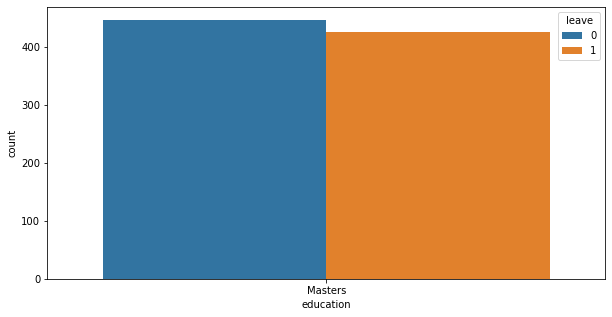

In [25]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["education"] == "Masters"]["education"], hue = df["leave"], dodge = True)
plt.show()

In [26]:
(df[df["education"] == "Masters"]["leave"].value_counts() / df[df["education"] == "Masters"].shape[0]) * 100

0    51.202749
1    48.797251
Name: leave, dtype: float64

### P3: Employees from Pune

50,4% of the employees from Pune left the company.

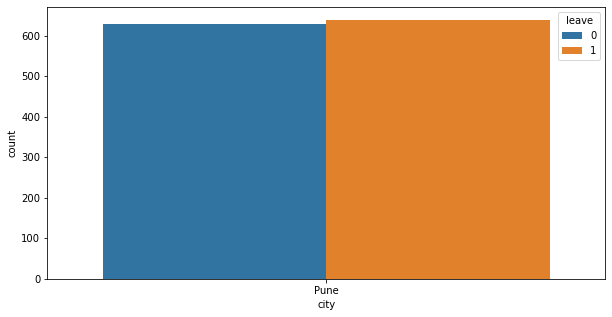

In [27]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["city"] == "Pune"]["city"], hue = df["leave"], dodge = True)
plt.show()

In [28]:
(df[df["city"] == "Pune"]["leave"].value_counts() / df[df["city"] == "Pune"].shape[0]) * 100

1    50.394322
0    49.605678
Name: leave, dtype: float64

### P4: Employees with median level payment

59,9% of the employees with median level payment left the company.

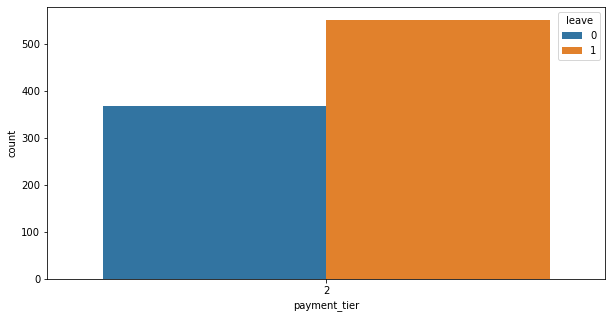

In [29]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["payment_tier"] == 2]["payment_tier"], hue = df["leave"], dodge = True)
plt.show()

In [30]:
(df[df["payment_tier"] == 2]["leave"].value_counts() / df[df["payment_tier"] == 2].shape[0]) * 100

1    59.912854
0    40.087146
Name: leave, dtype: float64

### P5: Female employees

47% of the  female employees left the company.

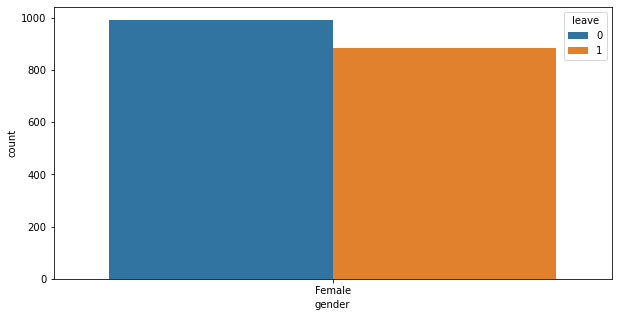

In [31]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["gender"] == "Female"]["gender"], hue = df["leave"], dodge = True)
plt.show()

In [32]:
(df[df["gender"] == "Female"]["leave"].value_counts() / df[df["gender"] == "Female"].shape[0]) * 100

0    52.853333
1    47.146667
Name: leave, dtype: float64

### P6: Employees who ever benched

45,4% of the employees who ever benched left the company.

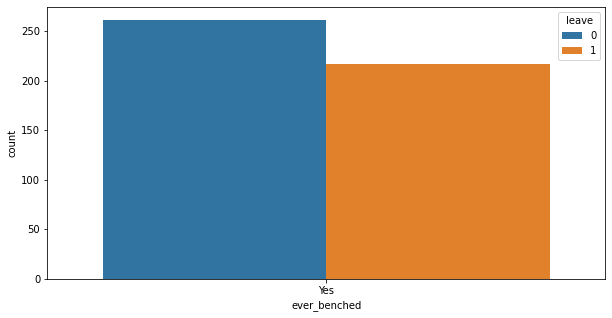

In [33]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["ever_benched"] == "Yes"]["ever_benched"], hue = df["leave"], dodge = True)
plt.show()

In [34]:
(df[df["ever_benched"] == "Yes"]["leave"].value_counts() / df[df["ever_benched"] == "Yes"].shape[0]) * 100

0    54.60251
1    45.39749
Name: leave, dtype: float64

In [35]:
df2 = df.copy()

# 4. Machine Learning

## 4.1 Pre-processing

### 4.1.1 Removing joining_year column

Removing this column because whe already have the same information processed on the time_employed column.

In [36]:
df2 = df.drop("joining_year", axis = 1)

### 4.1.2 One Hot Encoding

Transforming categorical columns to boolean.

In [37]:
df2.gender = df2.gender.replace({"Male":0, "Female":1})
df2.ever_benched = df2.ever_benched.replace({"No":0, "Yes":1})

col_ohe = ["education", "city", "payment_tier"]

for i in col_ohe:
    ohe = OneHotEncoder()
    df_temp = pd.DataFrame(ohe.fit_transform(df2[i].values.reshape(-1,1)).toarray(), columns = [str(i) + "_" + str(x) for x in ohe.categories_[0]])
    df2 = pd.concat([df2, df_temp], axis = 1)
    df2 = df2.drop(i, axis = 1)

### 4.1.3 Feature Selection

We will use some statistical tests to confirm the hypotheses generated by the bivariate analysis, discover new relationships and select the best variables for the model.

#### Chi² for categorical features

In [38]:
cat_col2 = ['gender', 'ever_benched', 'education_Bachelors', 'education_Masters',
            'education_PHD', 'city_Bangalore', 'city_New Delhi', 'city_Pune',
            'payment_tier_1', 'payment_tier_2', 'payment_tier_3']

In [39]:
df_chi2 = pd.DataFrame(columns = ["feature", "chi2", "p-value"])
for i in cat_col2:
    row = {"feature":i, "chi2": np.round(chi2(df2[i].values.reshape(-1, 1), df2["leave"].values.reshape(-1, 1))[0], 2), \
           "p-value":np.round(chi2(df2[i].values.reshape(-1, 1), df2["leave"].values.reshape(-1, 1))[1], 4)}
    
    df_chi2 = df_chi2.append(row, ignore_index = True)
    
df_chi2

,feature,chi2,p-value
0,gender,[135.31],[0.0]
1,ever_benched,[25.69],[0.0]
2,education_Bachelors,[14.69],[0.0001]
3,education_Masters,[80.35],[0.0]
4,education_PHD,[6.78],[0.0092]
5,city_Bangalore,[58.26],[0.0]
6,city_New Delhi,[3.89],[0.0487]
7,city_Pune,[144.01],[0.0]
8,payment_tier_1,[0.54],[0.4624]
9,payment_tier_2,[265.12],[0.0]


#### ANOVA for numerical features

In [40]:
df_anova = pd.DataFrame(columns = ["feature", "f-value", "p-value"])
for i in num_col:
    row = {"feature":i, "f-value": np.round(f_classif(df2[i].values.reshape(-1, 1), df2["leave"].values.reshape(-1, 1))[0], 2), \
           "p-value":np.round(f_classif(df2[i].values.reshape(-1, 1), df2["leave"].values.reshape(-1, 1))[1], 4)}
    
    df_anova = df_anova.append(row, ignore_index = True)
    
df_anova

,feature,f-value,p-value
0,age,[12.19],[0.0005]
1,experience_current_domain,[4.33],[0.0375]
2,time_employed,[158.8],[0.0]


In [41]:
df2 = df2.drop(["experience_current_domain", "city_New Delhi", "payment_tier_1"], axis = 1)

In [42]:
df2.head()

,age,gender,ever_benched,leave,time_employed,education_Bachelors,education_Masters,education_PHD,city_Bangalore,city_Pune,payment_tier_2,payment_tier_3
0,34,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28,1,0,1,5,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,1,0,0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,27,0,0,1,2,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,24,0,1,1,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0


### 4.1.4 Dividing train / test

Spliting the dataset in train and test.

In [43]:
X = df2.drop("leave", axis = 1)
y = df2["leave"]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 11)

### 4.1.5 Dealing with imbalanced data

To balance the target variable we will use an algorithm of oversampling, SVMSmote, this algorithm will create synthetic observations based on the observations that already exists.

In [44]:
sm = SVMSMOTE(k_neighbors = 4)
Xtrain_res, ytrain_res = sm.fit_resample(Xtrain, ytrain)

## 4.2 Modeling

### 4.2.1 LogisticRegression

In [45]:
logreg = LogisticRegression(class_weight = "balanced")
logreg.fit(Xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [46]:
evaluation = pd.DataFrame(columns = ["Modelo", "BalancedAc(treino)", "BalancedAc(Cross Val.)", "f1(treino)", "f1(Cross Val.)"])

model1_row = model_evaluation(Xtrain, ytrain, logreg, "Log.Regression")

evaluation = evaluation.append(model1_row, ignore_index = True)

In [47]:
evaluation

,Modelo,BalancedAc(treino),BalancedAc(Cross Val.),f1(treino),f1(Cross Val.)
0,Log.Regression,0.69,0.69,0.59,0.59


### 4.2.2 KNeighbors

In [47]:
knn = KNeighborsClassifier()
params = {"n_neighbors": Integer(1, 34),
          "weights": Categorical(["uniform", "distance"])}

bayes_search(Xtrain, ytrain, params, knn, "balanced_accuracy", n_folds = 5)

Melhores parâmetros: OrderedDict([('n_neighbors', 6), ('weights', 'distance')])

Melhor score: 0.7668377083501745


In [49]:
knn = KNeighborsClassifier(n_neighbors = 10, weights = "distance")
knn.fit(Xtrain, ytrain)

model2_row = model_evaluation(Xtrain, ytrain, knn, "Knn")

evaluation = evaluation.append(model2_row, ignore_index = True)
evaluation

,Modelo,BalancedAc(treino),BalancedAc(Cross Val.),f1(treino),f1(Cross Val.)
0,Log.Regression,0.69,0.69,0.59,0.59
1,RandomForest,0.83,0.81,0.78,0.76
2,Knn,0.87,0.76,0.85,0.68


### 4.2.3 RandomForest

In [49]:
forest = RandomForestClassifier(random_state = 11, class_weight= "balanced")
params = {"min_samples_split": Real(0.01, 0.5),
          "max_features": Categorical(["sqrt", "log2"]),
          "criterion": Categorical(["gini", "entropy"])}

bayes_search(Xtrain, ytrain, params, forest, "balanced_accuracy", n_folds = 5)

Melhores parâmetros: OrderedDict([('criterion', 'entropy'), ('max_features', 'sqrt'), ('min_samples_split', 0.01)])

Melhor score: 0.8157412764486779


In [48]:
forest = RandomForestClassifier(random_state = 11, class_weight = "balanced", min_samples_split = 0.01, n_estimators = 1000)
forest.fit(Xtrain, ytrain)

model3_row = model_evaluation(Xtrain, ytrain, forest, "RandomForest")

evaluation = evaluation.append(model3_row, ignore_index = True)
evaluation

,Modelo,BalancedAc(treino),BalancedAc(Cross Val.),f1(treino),f1(Cross Val.)
0,Log.Regression,0.69,0.69,0.59,0.59
1,RandomForest,0.83,0.81,0.78,0.76


## 4.3 Model evaluation on test

It can be seen that the best model was the Random Forest. We will now evaluate this model with the test dataset.

In [50]:
final_model = RandomForestClassifier(random_state = 11, class_weight = "balanced", min_samples_split = 0.01, n_estimators = 1000)
final_model.fit(Xtrain, ytrain)

RandomForestClassifier(class_weight='balanced', min_samples_split=0.01,
                       n_estimators=1000, random_state=11)

In [52]:
metrics = [balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score]
metric_grid = {}

for i in metrics:
    if i == roc_auc_score:
        metric_grid[str(metrics[metrics.index(i)]).split(' ')[1]] = i(y_true = ytest, y_score = final_model.predict_proba(Xtest)[:, 1])
    else:
        metric_grid[str(metrics[metrics.index(i)]).split(' ')[1]] = i(y_true = ytest, y_pred = final_model.predict(Xtest))
        
metric_grid

{'balanced_accuracy_score': 0.8320501184893864,
 'f1_score': 0.7856025039123631,
 'recall_score': 0.7606060606060606,
 'precision_score': 0.8122977346278317,
 'roc_auc_score': 0.889013260727071}

# 5. Conclusion

## 5.1 Relevant features of who left the company

First, human resources can use the insights below about employees to make the best decision.

- **Female employees.**
- **Employees who ever benched.**
- **Emplooyes with less time into the company.**
- **Employees with Master Degree.**
- **Employees from Pune.**
- **Employees with medium payment values.**

## 5.2 Using the model

The human resources area can use the classification model developed here to predict whether an employee will leave the company. The model will be made available by the Machine Learning engineering team on a web API for easy use by HR managers.

Our final model can predict if a employee will left the company in the next two years with a recall of 76%.

**This means that for all the employees that will definitively left the company, our model predict correctly 76% of they all.**

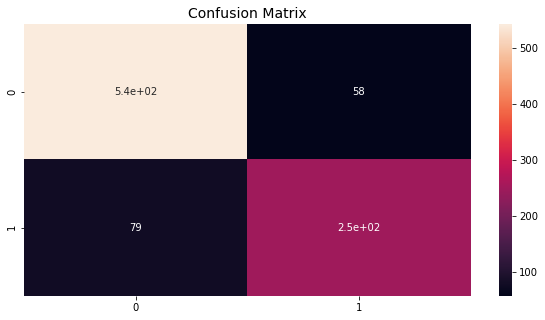

In [59]:
plt.figure(figsize = [10,5])
sns.heatmap(confusion_matrix(y_true = ytest, y_pred = final_model.predict(Xtest)), annot = True)
plt.title("Confusion Matrix", fontsize = 14)
plt.show()

In [61]:
confusion_matrix(y_true = ytest, y_pred = final_model.predict(Xtest))

array([[543,  58],
       [ 79, 251]], dtype=int64)

Here in the confusion matrix, we see that for 330 employees that left the company, the model predict correctly 251.

In [51]:
pickle.dump(final_model, open("employee_future_model.pkl", "wb"))